In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
  Obtaining dependency information for torch from https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchaudio from https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for filelock from https://download.pytorch.org/whl/filelock-3.19.1-py3-none-any.whl.metadata
  Obtaining dependency information for networkx from https://download.pytorch.org/whl/networkx-3.5-py3-none-any.whl.metadata
  Obtaining dependency information for jinja2 from https://download.pytorch.org/whl/jinja2-3.1.6-py3-none-any.whl.metadata
Discarding https://download.pytorch.org/whl/jinja2-3.1.6-py3-none-any.whl (from https://download.pytorch.org/w

In [2]:
%pip install opencv-python pandas ffmpeg-python matplotlib scikit-learn pytorchvideo ipywidgets

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
     ---------------------------------------- 11.3/11.3 MB 6.0 MB/s eta 0:00:00
     ---------------------------------------- 8.1/8.1 MB 5.2 MB/s eta 0:00:00
     ---------------------------------------- 8.1/8.1 MB 7.6 MB/s eta 0:00:00
     -------------------------------------- 132.7/132.7 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 139.8/139.8 kB 8.1 MB/s eta 0:00:00
     ---------------------------------------- 12.9/12.9 MB 8.1 MB/s eta 0:00:00
     ------------------------------------- 509.2/509.2 kB 10.6 MB/s eta 0:00:00
     ------------------------------------- 348.5/348.5 kB 10.9 MB/s eta 0:00:00
     -------------------------------------- 491.3/491.3 kB 7.6 MB/s eta 0:00:00
     -------------------------------------- 225.2/225.2 kB 4.6 MB/s eta 0:00:00
     ------------------------

  DEPRECATION: iopath is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  DEPRECATION: fvcore is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  DEPRECATION: pytorchvideo is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found

In [1]:
import torch
import cv2
import ffmpeg

print("--- System Check ---")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available:  {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Name:        {torch.cuda.get_device_name(0)}")
    print("SUCCESS: Your RTX 4070 is ready for training!")
else:
    print("WARNING: GPU not found. Training will be slow.")

print(f"OpenCV Version:  {cv2.__version__}")

--- System Check ---
PyTorch Version: 2.6.0+cu124
CUDA Available:  False
OpenCV Version:  4.11.0


In [4]:
import os
import re
import subprocess
import json
from datetime import datetime

# --- CONFIGURATION ---

VIDEO_FOLDER = "dataset" 


def get_creation_time(filepath):
    """Extracts creation_time from video metadata using ffprobe."""
    try:
        cmd = [
            'ffprobe', '-v', 'quiet', '-print_format', 'json',
            '-show_entries', 'format_tags=creation_time', 
            filepath
        ]
        # We use shell=True only if on Windows and commands aren't found, 
        # but since you added to PATH, it should work without it.
        result = subprocess.run(cmd, capture_output=True, text=True)
        data = json.loads(result.stdout)
        tags = data.get('format', {}).get('tags', {})
        time_str = tags.get('creation_time')
        
        if time_str:
            # Parse ISO 8601 format (e.g., 2025-10-24T14:05:01.000000Z)
            # We treat it as UTC
            return datetime.fromisoformat(time_str.replace('Z', '+00:00'))
        return None
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

def parse_video_id(filename):
    """Extracts the number from 'cam1.mp4' or 'Cam34.mp4'"""
    # Find all digits in the filename
    match = re.search(r'(\d+)', filename)
    if match:
        return int(match.group(1))
    return None

# 1. Scan and Pair Files
cam_files = {}
screen_files = {}

print(f"Scanning folder: {VIDEO_FOLDER}...")

if not os.path.exists(VIDEO_FOLDER):
    print(f"ERROR: Folder '{VIDEO_FOLDER}' does not exist.")
else:
    for f in os.listdir(VIDEO_FOLDER):
        if not f.endswith(('.mp4', '.mkv', '.mov', '.avi')):
            continue
            
        vid_id = parse_video_id(f)
        if vid_id is None:
            continue
            
        full_path = os.path.join(VIDEO_FOLDER, f)
        
        # Check if it is a cam or screen video (case insensitive check)
        lower_name = f.lower()
        if "cam" in lower_name:
            cam_files[vid_id] = full_path
        elif "screen" in lower_name:
            screen_files[vid_id] = full_path

    # 2. Analyze Pairs
    print(f"\nFound {len(cam_files)} cam videos and {len(screen_files)} screen videos.")
    print("-" * 60)
    print(f"{'ID':<5} | {'Cam Start':<20} | {'Screen Start':<20} | {'Offset (s)':<10}")
    print("-" * 60)

    common_ids = sorted(list(set(cam_files.keys()) & set(screen_files.keys())))

    for i in common_ids:
        c_path = cam_files[i]
        s_path = screen_files[i]
        
        t_cam = get_creation_time(c_path)
        t_screen = get_creation_time(s_path)
        
        if t_cam and t_screen:
            # Calculate difference in seconds
            diff = (t_cam - t_screen).total_seconds()
            
            # Formatting for display
            t_c_str = t_cam.strftime('%H:%M:%S')
            t_s_str = t_screen.strftime('%H:%M:%S')
            
            print(f"{i:<5} | {t_c_str:<20} | {t_s_str:<20} | {diff:.2f}")
        else:
            print(f"{i:<5} | {'Error/No Meta':<20} | {'Error/No Meta':<20} | N/A")

Scanning folder: dataset...

Found 103 cam videos and 102 screen videos.
------------------------------------------------------------
ID    | Cam Start            | Screen Start         | Offset (s)
------------------------------------------------------------
1     | Error/No Meta        | Error/No Meta        | N/A
2     | Error/No Meta        | Error/No Meta        | N/A
3     | Error/No Meta        | Error/No Meta        | N/A
4     | Error/No Meta        | Error/No Meta        | N/A
5     | Error/No Meta        | Error/No Meta        | N/A
6     | Error/No Meta        | Error/No Meta        | N/A
7     | Error/No Meta        | Error/No Meta        | N/A
8     | Error/No Meta        | Error/No Meta        | N/A
9     | Error/No Meta        | Error/No Meta        | N/A
10    | Error/No Meta        | Error/No Meta        | N/A
11    | Error/No Meta        | Error/No Meta        | N/A
12    | Error/No Meta        | Error/No Meta        | N/A
13    | Error/No Meta        | Error/No Meta

In [5]:
import subprocess
import json
import os

# CONFIGURATION
# Pick one pair that you think might have audio
cam_sample = "dataset/cam1.mp4" 
screen_sample = "dataset/screen1.mp4"

def check_audio_stream(filepath):
    if not os.path.exists(filepath):
        return "File not found"
        
    try:
        # Ask ffprobe for stream information
        cmd = [
            'ffprobe', '-v', 'quiet', '-print_format', 'json',
            '-show_streams', '-select_streams', 'a',  # 'a' looks for Audio only
            filepath
        ]
        result = subprocess.run(cmd, capture_output=True, text=True)
        data = json.loads(result.stdout)
        
        streams = data.get('streams', [])
        if len(streams) > 0:
            return f"YES (Audio Found: {streams[0].get('codec_name')})"
        else:
            return "NO Audio Stream"
            
    except Exception as e:
        return f"Error: {str(e)}"

print(f"--- Audio Check ---")
print(f"Cam1 Audio:    {check_audio_stream(cam_sample)}")
print(f"Screen1 Audio: {check_audio_stream(screen_sample)}")

--- Audio Check ---
Cam1 Audio:    YES (Audio Found: aac)
Screen1 Audio: YES (Audio Found: aac)


In [6]:
%pip install librosa scipy numpy

     -------------------------------------- 260.7/260.7 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 64.6/64.6 kB 3.4 MB/s eta 0:00:00
     -------------------------------------- 173.8/173.8 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 71.6/71.6 kB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 38.1/38.1 MB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 64.7/64.7 kB 1.8 MB/s eta 0:00:00
     -------------------------------------- 182.8/182.8 kB 3.7 MB/s eta 0:00:00
     -------------------------------------- 118.1/118.1 kB 3.5 MB/s eta 0:00:00
     -------------------------------------- 107.0/107.0 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 71.0/71.0 kB 4.1 MB/s eta 0:00:00
     -------------------------------------- 

In [7]:
import librosa
import numpy as np
from scipy import signal
import os

# --- CONFIGURATION ---
FILE_CAM = "dataset/cam1.mp4"
FILE_SCREEN = "dataset/screen1.mp4"
# ---------------------

def find_audio_offset(file1, file2, duration=60):
    print(f"Loading audio from {file1}...")
    # Load audio (mono, original sample rate)
    try:
        y1, sr1 = librosa.load(file1, duration=duration, mono=True)
        y2, sr2 = librosa.load(file2, duration=duration, mono=True)
    except Exception as e:
        return f"Error loading audio: {str(e)}"

    print("Audio loaded. Calculating synchronization...")
    
    # Resample if rates are different (rare, but good safety)
    if sr1 != sr2:
        print("Resampling audio to match...")
        # We assume sr1 is the target
        y2 = librosa.resample(y2, orig_sr=sr2, target_sr=sr1)
        sr = sr1
    else:
        sr = sr1

    # Cross-correlation (The Math Magic)
    # This finds the point where the two signals are most similar
    correlation = signal.correlate(y1, y2, mode='full')
    lags = signal.correlation_lags(len(y1), len(y2), mode='full')
    
    # Find the peak correlation
    peak_idx = np.argmax(correlation)
    lag_samples = lags[peak_idx]
    
    # Convert samples to seconds
    offset_seconds = lag_samples / sr
    
    return offset_seconds

if not os.path.exists(FILE_CAM) or not os.path.exists(FILE_SCREEN):
    print("Error: Check your filenames. I can't find cam1 or screen1.")
else:
    offset = find_audio_offset(FILE_CAM, FILE_SCREEN)
    
    print("-" * 40)
    print(f"Calculated Offset: {offset:.4f} seconds")
    print("-" * 40)
    
    if offset > 0:
        print(f"INTERPRETATION: 'Cam' starts {offset:.2f}s BEFORE 'Screen'.")
        print("We need to trim the start of Cam.")
    elif offset < 0:
        print(f"INTERPRETATION: 'Screen' starts {abs(offset):.2f}s BEFORE 'Cam'.")
        print("We need to trim the start of Screen.")
    else:
        print("Perfectly synced (or audio was silent).")

Loading audio from dataset/cam1.mp4...


C:\Users\janak\AppData\Local\Temp\ipykernel_27192\1469134873.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y1, sr1 = librosa.load(file1, duration=duration, mono=True)
c:\Users\janak\OneDrive\Desktop\VideoAnalyzer\.venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\janak\AppData\Local\Temp\ipykernel_27192\1469134873.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  y2, sr2 = librosa.load(file2, duration=duration, mono=True)
c:\Users\janak\OneDrive\Desktop\VideoAnalyzer\.venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio loaded. Calculating synchronization...
----------------------------------------
Calculated Offset: -60.0000 seconds
----------------------------------------
INTERPRETATION: 'Screen' starts 60.00s BEFORE 'Cam'.
We need to trim the start of Screen.


C:\Users\janak\AppData\Local\Temp\ipykernel_27192\2377665757.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y1, sr1 = librosa.load(FILE_CAM, duration=30, mono=True)
c:\Users\janak\OneDrive\Desktop\VideoAnalyzer\.venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\janak\AppData\Local\Temp\ipykernel_27192\2377665757.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  y2, sr2 = librosa.load(FILE_SCREEN, duration=30, mono=True)


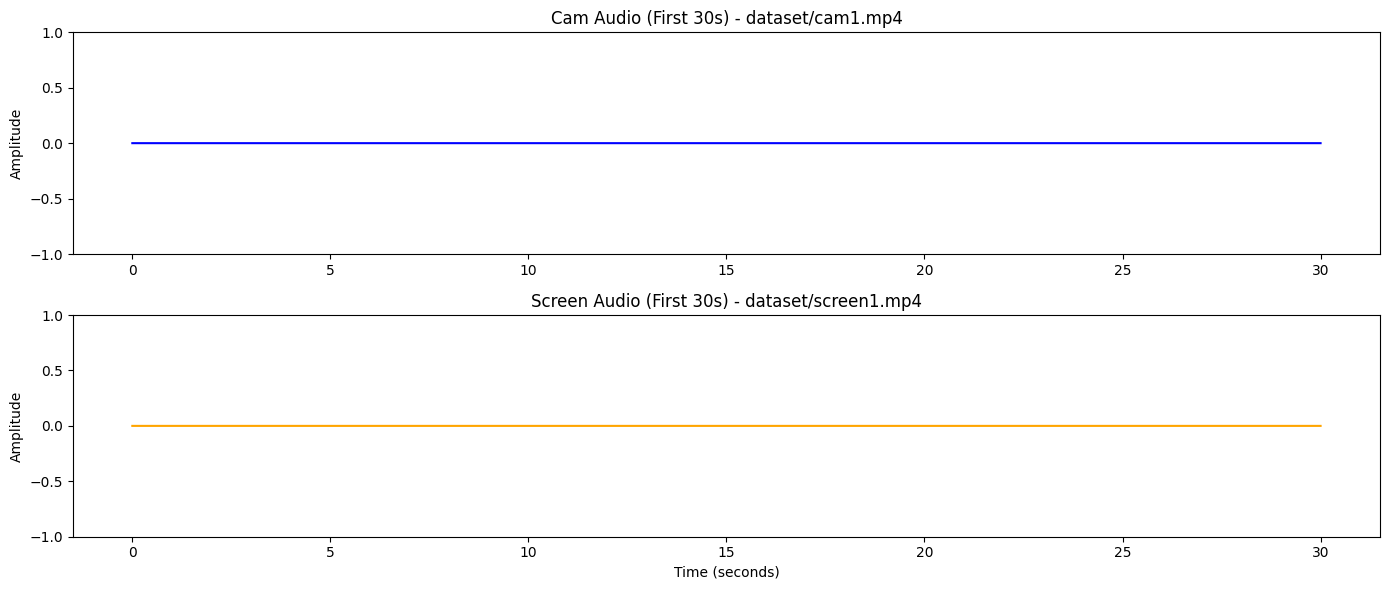

In [8]:
import matplotlib.pyplot as plt
import librosa
import numpy as np

# --- CONFIGURATION ---
FILE_CAM = "dataset/cam1.mp4"
FILE_SCREEN = "dataset/screen1.mp4"
# ---------------------

plt.figure(figsize=(14, 6))

# Load and Plot Cam Audio
try:
    y1, sr1 = librosa.load(FILE_CAM, duration=30, mono=True)
    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, 30, len(y1)), y1, color='blue')
    plt.title(f"Cam Audio (First 30s) - {FILE_CAM}")
    plt.ylabel("Amplitude")
    plt.ylim(-1, 1)
except Exception as e:
    print(f"Could not load Cam audio: {e}")

# Load and Plot Screen Audio
try:
    y2, sr2 = librosa.load(FILE_SCREEN, duration=30, mono=True)
    plt.subplot(2, 1, 2)
    plt.plot(np.linspace(0, 30, len(y2)), y2, color='orange')
    plt.title(f"Screen Audio (First 30s) - {FILE_SCREEN}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.ylim(-1, 1)
except Exception as e:
    print(f"Could not load Screen audio: {e}")

plt.tight_layout()
plt.show()

In [1]:
import os
import re
import pandas as pd
import cv2

# --- CONFIGURATION ---
VIDEO_FOLDER = "dataset" 
OUTPUT_CSV = "video_inventory.csv"
# ---------------------

def get_video_info(path):
    """Returns frame count, fps, and duration."""
    try:
        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            return None, None, None
        
        frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = frames / fps if fps > 0 else 0
        
        cap.release()
        return frames, fps, duration
    except:
        return None, None, None

def parse_id(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else None

data_list = []
print("Scanning dataset to build inventory...")

# Group by ID
files = os.listdir(VIDEO_FOLDER)
pairs = {}

for f in files:
    if not f.endswith(('.mp4', '.avi', '.mkv')):
        continue
    
    vid_id = parse_id(f)
    if vid_id is None:
        continue
        
    full_path = os.path.join(VIDEO_FOLDER, f)
    
    if vid_id not in pairs:
        pairs[vid_id] = {'cam': None, 'screen': None}
        
    if "cam" in f.lower():
        pairs[vid_id]['cam'] = full_path
    elif "screen" in f.lower():
        pairs[vid_id]['screen'] = full_path

# Build the Table
for vid_id, pair in sorted(pairs.items()):
    cam_path = pair['cam']
    screen_path = pair['screen']
    
    # Only process complete pairs
    if cam_path and screen_path:
        # Get Technical Details (Check for corruption)
        c_frames, c_fps, c_dur = get_video_info(cam_path)
        s_frames, s_fps, s_dur = get_video_info(screen_path)
        
        if c_frames is None or s_frames is None:
            print(f"Warning: ID {vid_id} is corrupted/unreadable.")
            continue
            
        data_list.append({
            'id': vid_id,
            'cam_path': cam_path,
            'screen_path': screen_path,
            'cam_fps': round(c_fps, 2),
            'screen_fps': round(s_fps, 2),
            'duration_cam': round(c_dur, 2),
            'duration_screen': round(s_dur, 2)
        })

# Save to CSV
df = pd.DataFrame(data_list)
df.to_csv(OUTPUT_CSV, index=False)

print("-" * 50)
print(f"Inventory saved to {OUTPUT_CSV}")
print(f"Total Valid Pairs: {len(df)}")
print("-" * 50)
print(df.head())

Scanning dataset to build inventory...
--------------------------------------------------
Inventory saved to video_inventory.csv
Total Valid Pairs: 102
--------------------------------------------------
   id          cam_path          screen_path  cam_fps  screen_fps  \
0   1  dataset\cam1.mp4  dataset\screen1.mp4     60.0        60.0   
1   2  dataset\cam2.mp4  dataset\screen2.mp4     60.0        60.0   
2   3  dataset\cam3.mp4  dataset\screen3.mp4     60.0        60.0   
3   4  dataset\cam4.mp4  dataset\screen4.mp4     60.0        60.0   
4   5  dataset\cam5.mp4  dataset\screen5.mp4     60.0        60.0   

   duration_cam  duration_screen  
0        211.08           211.32  
1        216.58           218.45  
2        271.48           271.25  
3        194.70           209.95  
4        147.05           148.15  


In [2]:
%pip install deepface tf-keras

     ------------------------------------ 133.1/133.1 kB 218.7 kB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 883.6 kB/s eta 0:00:00
     -------------------------------------- 331.8/331.8 MB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 2.6 MB/s eta 0:00:00
     -------------------------------------- 103.3/103.3 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 3.5 MB/s eta 0:00:00
     -------------------------------------- 115.9/115.9 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 85.0/85.0 kB 5.0 MB/s eta 0:00:00
     ---------------------------------------- 59.4/59.4 kB 3.1 MB/s eta 0:00:00
     -------------------------------------- 108.3/108.3 kB 3.2 MB/s eta 0:00:00
     -------------------------------------- 225.0/225.0 kB 4.7 MB/s eta 0:00:00
     -------------------------------------- 107.7/107.7 kB 1.6 MB/s eta 0:00:00
     -------------------------------------- 

  DEPRECATION: atomicwrites is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559


In [3]:
import pandas as pd
import cv2
from deepface import DeepFace
import os
import numpy as np

# --- CONFIGURATION ---
CSV_FILE = "video_inventory.csv"
OUTPUT_CSV = "labeled_dataset.csv"
SAMPLE_RATE = 30  # Analyze 1 frame every 30 frames (approx 1 per sec at 30fps)
# ---------------------

def analyze_emotions(video_path):
    """Scans a video and returns the % of frames showing negative emotion."""
    cap = cv2.VideoCapture(video_path)
    total_frames = 0
    negative_frames = 0
    
    # We look for these "Frustration" indicators
    negative_emotions = ['angry', 'disgust', 'fear', 'sad']
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        total_frames += 1
        
        # Skip frames to speed up (process 1 frame every second roughly)
        if total_frames % SAMPLE_RATE != 0:
            continue
            
        try:
            # DeepFace expects RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Analyze face (enforce_detection=False skips frames with no face)
            result = DeepFace.analyze(rgb_frame, actions=['emotion'], 
                                    enforce_detection=False, silent=True)
            
            # Result is a list of dicts (one for each face found)
            if result:
                # Get dominant emotion
                emotion = result[0]['dominant_emotion']
                if emotion in negative_emotions:
                    negative_frames += 1
                    
        except Exception as e:
            pass # Skip frames where face detection fails
            
    cap.release()
    
    # Calculate Frustration Score
    scanned_frames = total_frames // SAMPLE_RATE
    if scanned_frames == 0: return 0.0
    
    frustration_score = negative_frames / scanned_frames
    return frustration_score

# --- MAIN LOOP ---
print("Loading Inventory...")
df = pd.read_csv(CSV_FILE)
df['frustration_score'] = 0.0
df['label'] = 0  # Default to PASS

print(f"Starting Auto-Labeling for {len(df)} videos...")
print("This uses the 'cam' video to detect user frustration.")

for index, row in df.iterrows():
    cam_path = row['cam_path']
    vid_id = row['id']
    
    if os.path.exists(cam_path):
        print(f"Processing ID {vid_id}...", end="")
        
        score = analyze_emotions(cam_path)
        df.at[index, 'frustration_score'] = round(score, 3)
        
        # HEURISTIC RULE:
        # If user is frustrated in more than 10% of the video -> Label as FAIL (1)
        if score > 0.10:
            df.at[index, 'label'] = 1
            print(f" -> FLAGGED (Frustration: {score:.1%})")
        else:
            print(f" -> CLEAN (Frustration: {score:.1%})")
            
    # Save periodically
    if index % 5 == 0:
        df.to_csv(OUTPUT_CSV, index=False)

# Final Save
df.to_csv(OUTPUT_CSV, index=False)
print("-" * 50)
print("Auto-Labeling Complete!")
print(f"Saved to {OUTPUT_CSV}")
print("Breakdown:")
print(df['label'].value_counts())


25-12-14 03:13:45 - Directory C:\Users\janak\.deepface has been created
25-12-14 03:13:45 - Directory C:\Users\janak\.deepface\weights has been created
Loading Inventory...
Starting Auto-Labeling for 102 videos...
This uses the 'cam' video to detect user frustration.
Processing ID 1...25-12-14 03:13:46 - 🔗 facial_expression_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5 to C:\Users\janak\.deepface\weights\facial_expression_model_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: C:\Users\janak\.deepface\weights\facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:09<00:00, 651kB/s]


 -> CLEAN (Frustration: 9.0%)
Processing ID 2... -> FLAGGED (Frustration: 72.7%)
Processing ID 3... -> FLAGGED (Frustration: 24.5%)
Processing ID 4... -> FLAGGED (Frustration: 33.2%)
Processing ID 5... -> FLAGGED (Frustration: 91.5%)
Processing ID 6... -> FLAGGED (Frustration: 24.9%)
Processing ID 7... -> FLAGGED (Frustration: 42.7%)
Processing ID 8... -> CLEAN (Frustration: 0.6%)
Processing ID 9... -> FLAGGED (Frustration: 20.7%)
Processing ID 10... -> CLEAN (Frustration: 5.8%)
Processing ID 11... -> CLEAN (Frustration: 3.6%)
Processing ID 12... -> FLAGGED (Frustration: 31.3%)
Processing ID 13... -> CLEAN (Frustration: 5.3%)
Processing ID 14... -> FLAGGED (Frustration: 20.1%)
Processing ID 15... -> CLEAN (Frustration: 4.6%)
Processing ID 16... -> FLAGGED (Frustration: 12.5%)
Processing ID 17... -> CLEAN (Frustration: 2.8%)
Processing ID 18... -> CLEAN (Frustration: 5.9%)
Processing ID 19... -> FLAGGED (Frustration: 12.2%)
Processing ID 20... -> FLAGGED (Frustration: 56.3%)
Processing 

In [4]:
from sklearn.model_selection import train_test_split

# Load the labeled data
df = pd.read_csv("labeled_dataset.csv")

# Split 80% Train, 20% Validation
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Save separate CSVs
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)

print(f"Training Videos:   {len(train_df)}")
print(f"Validation Videos: {len(val_df)}")

Training Videos:   81
Validation Videos: 21


In [6]:
import sys
import torchvision

# --- HOTFIX FOR PYTORCHVIDEO ---
# PytorchVideo looks for 'functional_tensor' which was removed in newer TorchVision.
# We map it to the new location 'functional'.
sys.modules['torchvision.transforms.functional_tensor'] = torchvision.transforms.functional
# -------------------------------

import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import pandas as pd # Make sure pandas is imported

# Now we can safely import pytorchvideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample
)
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import CenterCropVideo, NormalizeVideo

class VideoDataset(Dataset):
    def __init__(self, csv_file, transform=None, num_frames=32):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.num_frames = num_frames
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # 1. Get Path and Label
        row = self.df.iloc[idx]
        video_path = row['screen_path'] # We train on SCREEN first
        label = int(row['label'])
        
        # 2. Load Video
        frames = self._load_video(video_path)
        
        # 3. Apply Transforms (Resize, Normalize)
        if self.transform:
            frames = self.transform(frames)
            
        return frames, label

    def _load_video(self, path):
        """Reads video frames using OpenCV"""
        cap = cv2.VideoCapture(path)
        frames = []
        try:
            while True:
                ret, frame = cap.read()
                if not ret: break
                # Convert BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
        finally:
            cap.release()
            
        if len(frames) == 0:
            # Return blank tensor if video fails
            return torch.zeros((3, self.num_frames, 256, 256))

        # Convert to Tensor (C, T, H, W)
        video_tensor = torch.from_numpy(np.array(frames))
        video_tensor = video_tensor.permute(3, 0, 1, 2) 
        
        return video_tensor

print("Dataset Class Defined Successfully (with Hotfix).")

Dataset Class Defined Successfully (with Hotfix).


In [7]:
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
) 
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import NormalizeVideo

# Define the Transforms (Resize -> Crop -> Normalize)
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32 # Model sees 32 frames at a time

transform = ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x / 255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(size=side_size),
            CenterCropVideo(crop_size),
        ]
    ),
)

# Pack Pathway Logic for SlowFast
# Alpha=4 means Fast path has 4x more frames (or sample rate diff)
def pack_pathway_output(frames):
    fast_pathway = frames
    # Slow pathway: subsample by factor of 4
    slow_pathway = torch.index_select(
        frames,
        1,
        torch.linspace(0, frames.shape[1] - 1, frames.shape[1] // 4).long(),
    )
    frame_list = [slow_pathway, fast_pathway]
    return frame_list

# Instantiate
dataset = VideoDataset(csv_file="train.csv", num_frames=num_frames)

print("Testing Loader...")
# Manually grab one item
raw_video, label = dataset[0] # Grab first video

# Apply Transform manually to check
video_data = {"video": raw_video}
video_data = transform(video_data)
final_input = pack_pathway_output(video_data["video"])

print(f"Label: {label}")
print(f"Slow Pathway Shape: {final_input[0].shape} (Channels, Frames, Height, Width)")
print(f"Fast Pathway Shape: {final_input[1].shape}")

if final_input[0].shape[0] == 3 and final_input[0].shape[2] == 256:
    print("SUCCESS: Data shapes are correct for SlowFast!")
else:
    print("ERROR: Shapes are wrong.")

Testing Loader...
Label: 0
Slow Pathway Shape: torch.Size([3, 8, 256, 256]) (Channels, Frames, Height, Width)
Fast Pathway Shape: torch.Size([3, 32, 256, 256])
SUCCESS: Data shapes are correct for SlowFast!


In [3]:
import torch
import torch.nn as nn

def get_model(num_classes=2):
    # 1. Load pre-trained SlowFast from PyTorch Hub
    # This downloads the weights (approx 300MB) the first time you run it.
    model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)
    
    # 2. Freeze the early layers (Optional but recommended for small datasets)
    # This prevents the model from forgetting "basic vision" while learning your UI.
    # for param in model.parameters():
    #     param.requires_grad = False
        
    # 3. Perform Surgery on the Head
    # The original model ends with a projection layer for 400 classes.
    # We find that layer and replace it.
    # In SlowFast, the head is typically at model.blocks[-1].proj
    
    input_features = model.blocks[-1].proj.in_features
    model.blocks[-1].proj = nn.Linear(input_features, num_classes)
    
    return model

# Initialize
print("Downloading/Loading SlowFast Model...")
model = get_model(num_classes=2)

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model loaded and moved to {device}")
print("New Output Layer:", model.blocks[-1].proj) 
# Should see: Linear(in_features=2304, out_features=2, bias=True)

Downloading/Loading SlowFast Model...


Using cache found in C:\Users\janak/.cache\torch\hub\facebookresearch_pytorchvideo_main


Model loaded and moved to cuda
New Output Layer: Linear(in_features=2304, out_features=2, bias=True)


In [4]:
import sys
import torchvision
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import pandas as pd

# --- HOTFIX RE-APPLY ---
sys.modules['torchvision.transforms.functional_tensor'] = torchvision.transforms.functional
# -----------------------

class VideoDataset(Dataset):
    def __init__(self, csv_file, transform=None, num_frames=32):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.num_frames = num_frames
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = row['screen_path']
        label = int(row['label'])
        
        # 1. Load and Resize
        frames = self._load_video(video_path)
        
        # 2. Apply Transforms
        # CRITICAL FIX: Wrap in dictionary for pytorchvideo
        if self.transform:
            video_data = {"video": frames} 
            video_data = self.transform(video_data)
            frames = video_data["video"] # Extract back out
            
        return frames, label

    def _load_video(self, path):
        """Reads video frames, resizing them instantly to save RAM."""
        cap = cv2.VideoCapture(path)
        frames = []
        try:
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            # Skip frames to save time/memory
            skip_step = max(1, total_frames // 64) 
            
            count = 0
            while True:
                ret, frame = cap.read()
                if not ret: break
                
                if count % skip_step == 0:
                    # Resize to 256x256
                    frame = cv2.resize(frame, (256, 256))
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame)
                
                count += 1
        finally:
            cap.release()
            
        if len(frames) == 0:
            return torch.zeros((3, self.num_frames, 256, 256))

        # Convert to Tensor (C, T, H, W)
        video_tensor = torch.from_numpy(np.array(frames))
        video_tensor = video_tensor.permute(3, 0, 1, 2) 
        
        return video_tensor

print("Dataset Class Updated (Dictionary Fix Applied).")

Dataset Class Updated (Dictionary Fix Applied).


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import CenterCropVideo, NormalizeVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample
)

# --- RE-LOAD MODEL ---
# (We reload to be safe, though not strictly necessary if previous cell ran)
def get_model(num_classes=2):
    model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)
    input_features = model.blocks[-1].proj.in_features
    model.blocks[-1].proj = nn.Linear(input_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=2)
model = model.to(device)
print(f"Model loaded on {device}")

# --- HYPERPARAMETERS ---
BATCH_SIZE = 4
LEARNING_RATE = 0.001
NUM_EPOCHS = 5

# --- TRANSFORMS ---
transform = ApplyTransformToKey(
    key="video",
    transform=Compose([
        UniformTemporalSubsample(32),
        Lambda(lambda x: x / 255.0),
        NormalizeVideo([0.45, 0.45, 0.45], [0.225, 0.225, 0.225]),
        ShortSideScale(size=256),
        CenterCropVideo(256),
    ]),
)

# --- DATA LOADERS ---
# (Assumes VideoDataset is defined from previous steps)
train_dataset = VideoDataset(csv_file="train.csv", transform=transform)
val_dataset = VideoDataset(csv_file="val.csv", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- OPTIMIZER ---
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

def pack_pathway(frames):
    """Creates Slow and Fast pathways from the video tensor."""
    fast = frames
    # Subsample for Slow pathway (every 4th frame)
    indices = torch.linspace(0, frames.shape[2] - 1, frames.shape[2] // 4).long()
    
    # CRITICAL FIX: Move indices to the same device as the video (GPU)
    indices = indices.to(frames.device)
    
    slow = torch.index_select(frames, 2, indices)
    return [slow, fast]

# --- TRAINING LOOP ---
print(f"Starting Training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    
    for i, (video_batch, labels) in enumerate(train_loader):
        # Move inputs to GPU
        video_batch = video_batch.to(device)
        labels = labels.to(device)
        
        # Prepare Inputs (Now safe because indices move to GPU too)
        inputs = pack_pathway(video_batch)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward Pass
        loss.backward()
        optimizer.step()
        
        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if i % 5 == 0:
            print(f"Batch {i}: Loss = {loss.item():.4f}")

    train_acc = 100 * correct / total
    print(f"Train Accuracy: {train_acc:.2f}% | Avg Loss: {running_loss/len(train_loader):.4f}")

    # Validation Phase
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for video_batch, labels in val_loader:
            video_batch = video_batch.to(device)
            labels = labels.to(device)
            inputs = pack_pathway(video_batch)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.2f}%")
    
    # Save the model state
    torch.save(model.state_dict(), "last_model.pth")

print("\nTRAINING COMPLETE.")

Using cache found in C:\Users\janak/.cache\torch\hub\facebookresearch_pytorchvideo_main


Model loaded on cuda
Starting Training for 5 epochs...

--- Epoch 1/5 ---
Batch 0: Loss = 0.7511
Batch 5: Loss = 0.6088
Batch 10: Loss = 0.4846
Batch 15: Loss = 0.7605
Batch 20: Loss = 1.1983
Train Accuracy: 58.02% | Avg Loss: 0.7174
Validation Accuracy: 61.90%

--- Epoch 2/5 ---
Batch 0: Loss = 0.8042
Batch 5: Loss = 1.0805
Batch 10: Loss = 0.6124
Batch 15: Loss = 0.4326
Batch 20: Loss = 0.2408
Train Accuracy: 55.56% | Avg Loss: 0.6623
Validation Accuracy: 61.90%

--- Epoch 3/5 ---
Batch 0: Loss = 0.5567
Batch 5: Loss = 0.7762
Batch 10: Loss = 0.4542
Batch 15: Loss = 0.4847
Batch 20: Loss = 0.8718
Train Accuracy: 71.60% | Avg Loss: 0.5597
Validation Accuracy: 42.86%

--- Epoch 4/5 ---
Batch 0: Loss = 0.4072
Batch 5: Loss = 0.2513
Batch 10: Loss = 0.2991
Batch 15: Loss = 0.3583
Batch 20: Loss = 0.4060
Train Accuracy: 90.12% | Avg Loss: 0.4033
Validation Accuracy: 42.86%

--- Epoch 5/5 ---
Batch 0: Loss = 0.3667
Batch 5: Loss = 0.1686
Batch 10: Loss = 0.3250
Batch 15: Loss = 0.3279
Batc

In [8]:
import pandas as pd
import torch
import cv2
import numpy as np
import random
from pytorchvideo.transforms import ApplyTransformToKey, ShortSideScale, UniformTemporalSubsample
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import CenterCropVideo, NormalizeVideo

# --- RE-DEFINE ARCHITECTURE (Must match training) ---
def get_model(num_classes=2):
    model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)
    input_features = model.blocks[-1].proj.in_features
    model.blocks[-1].proj = torch.nn.Linear(input_features, num_classes)
    return model

def pack_pathway(frames):
    """Creates Slow and Fast pathways."""
    fast = frames
    indices = torch.linspace(0, frames.shape[2] - 1, frames.shape[2] // 4).long().to(frames.device)
    slow = torch.index_select(frames, 2, indices)
    return [slow, fast]

# --- LOAD SAVED MODEL ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading model on {device}...")

model = get_model(num_classes=2)
# Load the weights we just trained
model.load_state_dict(torch.load("last_model.pth"))
model = model.to(device)
model.eval() # Switch to evaluation mode

# --- DEFINE TRANSFORM ---
transform = ApplyTransformToKey(
    key="video",
    transform=Compose([
        UniformTemporalSubsample(32),
        Lambda(lambda x: x / 255.0),
        NormalizeVideo([0.45, 0.45, 0.45], [0.225, 0.225, 0.225]),
        ShortSideScale(size=256),
        CenterCropVideo(256),
    ]),
)

# --- PICK A TEST VIDEO ---
# We pick a random one from your list
df = pd.read_csv("val.csv")
random_row = df.sample(1).iloc[0]
video_path = random_row['screen_path']
actual_label = int(random_row['label'])

print(f"\n🎥 Testing Video: {video_path}")
print(f"👀 Actual Label:  {'FAIL (Bug)' if actual_label == 1 else 'PASS (Clean)'}")

# --- PROCESS & PREDICT ---
def predict(path):
    # 1. Read Video
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        skip_step = max(1, total_frames // 64) 
        count = 0
        while True:
            ret, frame = cap.read()
            if not ret: break
            if count % skip_step == 0:
                frame = cv2.resize(frame, (256, 256))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            count += 1
    finally:
        cap.release()

    if len(frames) == 0: return "Error", 0.0

    # 2. Prepare Tensor
    video_tensor = torch.from_numpy(np.array(frames)).permute(3, 0, 1, 2)
    video_data = {"video": video_tensor}
    video_data = transform(video_data)
    
    # 3. Pack Pathway & Move to GPU
    inputs = pack_pathway(video_data["video"].unsqueeze(0)) # Add batch dim
    inputs = [i.to(device) for i in inputs]
    
    # 4. Predict
    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        # Class 0 = PASS, Class 1 = FAIL
        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_idx].item()
        
    return pred_idx, confidence

pred, conf = predict(video_path)

print("-" * 30)
if pred == 1:
    print(f"🤖 AI Prediction: FAIL (Bug Detected)")
else:
    print(f"🤖 AI Prediction: PASS (Works Fine)")
    
print(f"📊 Confidence:    {conf:.1%}")

if pred == actual_label:
    print("✅ CORRECT!")
else:
    print("❌ WRONG (Likely due to overfitting)")

Loading model on cuda...


Using cache found in C:\Users\janak/.cache\torch\hub\facebookresearch_pytorchvideo_main



🎥 Testing Video: dataset\screen47.mkv
👀 Actual Label:  FAIL (Bug)
------------------------------
🤖 AI Prediction: FAIL (Bug Detected)
📊 Confidence:    92.0%
✅ CORRECT!


In [9]:
%pip install ultralytics

     ---------------------------------------- 1.2/1.2 MB 2.4 MB/s eta 0:00:00
     -------------------------------------- 802.4/802.4 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 44.5/44.5 MB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
import cv2
import numpy as np
from ultralytics import YOLO

# --- CONFIGURATION ---
VIDEO_PATH = "dataset/screen47.mkv"
YOLO_MODEL_PATH = "best.pt" 
OUTPUT_PATH = "final_diagnosis.mp4"
# ---------------------

def analyze_failure_with_yolo(video_path, model_path, output_path):
    print(f"Loading YOLO model from {model_path}...")
    try:
        model = YOLO(model_path)
    except Exception as e:
        print(f"Error loading YOLO: {e}")
        print("Make sure you have the 'best.pt' file in your folder!")
        return

    cap = cv2.VideoCapture(video_path)
    
    # --- STEP 1: FIND THE 'RAGE CLICK' ZONE (HEATMAP) ---
    print("Step 1: Analyzing user behavior (Motion Tracking)...")
    
    ret, first_frame = cap.read()
    if not ret: return

    heatmap = np.zeros((first_frame.shape[0], first_frame.shape[1]), dtype=np.float32)
    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        diff = cv2.absdiff(prev_gray, gray)
        _, thresh = cv2.threshold(diff, 15, 255, cv2.THRESH_BINARY)
        heatmap = cv2.add(heatmap, thresh.astype(np.float32))
        prev_gray = gray

    # Find the precise (X, Y) coordinate of the struggle
    heatmap_blur = cv2.GaussianBlur(heatmap, (51, 51), 0)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(heatmap_blur)
    struggle_point = maxLoc # (x, y)
    
    print(f"User struggled most at coordinates: {struggle_point}")

    # --- STEP 2: IDENTIFY THE FEATURE (YOLO) ---
    print("Step 2: Identifying the UI element (YOLO Scan)...")
    
    # We grab the frame where the heatmap was hottest (or just the first frame/middle frame)
    # Usually UI elements don't move, so checking the middle frame is safe.
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(cap.get(cv2.CAP_PROP_FRAME_COUNT) / 2))
    ret, frame_to_scan = cap.read()
    
    # Run YOLO Inference
    results = model(frame_to_scan)
    
    culprit_box = None
    culprit_name = "Unknown Area"
    
    # Check which box contains the 'Struggle Point'
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get coordinates (x1, y1, x2, y2)
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            cls_id = int(box.cls[0])
            label = model.names[cls_id]
            
            # Check intersection: Is the struggle point inside this box?
            if x1 <= struggle_point[0] <= x2 and y1 <= struggle_point[1] <= y2:
                culprit_box = (int(x1), int(y1), int(x2), int(y2))
                culprit_name = label
                print(f"MATCH FOUND: User was struggling with '{label}'")
                break
        if culprit_box: break

    # --- STEP 3: VISUALIZE RESULT ---
    print("Step 3: Generating Final Report Video...")
    cap = cv2.VideoCapture(video_path)
    
    # Setup Writer
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        
        # 1. Draw the "Struggle Point" (Red Crosshair)
        cv2.drawMarker(frame, struggle_point, (0, 0, 255), cv2.MARKER_CROSS, 30, 2)
        
        # 2. Draw the "Culprit Box" (YOLO Detection)
        if culprit_box:
            cv2.rectangle(frame, (culprit_box[0], culprit_box[1]), (culprit_box[2], culprit_box[3]), (0, 255, 0), 3)
            
            # Label
            text = f"FAIL: {culprit_name}"
            cv2.putText(frame, text, (culprit_box[0], culprit_box[1]-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        else:
            # If YOLO didn't find a button there, just label the area
            cv2.putText(frame, "FAIL: Unrecognized Area", (struggle_point[0], struggle_point[1]-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        out.write(frame)
        
    cap.release()
    out.release()
    print(f"Done! Final diagnosis saved to {output_path}")

# Run it
analyze_failure_with_yolo(VIDEO_PATH, YOLO_MODEL_PATH, OUTPUT_PATH)

Loading YOLO model from best.pt...
Step 1: Analyzing user behavior (Motion Tracking)...
User struggled most at coordinates: (315, 536)
Step 2: Identifying the UI element (YOLO Scan)...

0: 352x640 11 buttons, 6 headings, 4 images, 35.7ms
Speed: 5.2ms preprocess, 35.7ms inference, 5.2ms postprocess per image at shape (1, 3, 352, 640)
MATCH FOUND: User was struggling with 'image'
Step 3: Generating Final Report Video...
Done! Final diagnosis saved to final_diagnosis.mp4


In [11]:
import cv2
import numpy as np

# --- CONFIGURATION ---
VIDEO_PATH = "dataset/screen47.mkv"  # <--- Change this to your video file
OUTPUT_PATH = "highlighted_failure.mp4"
# ---------------------

def create_failure_heatmap(video_path, output_path):
    print(f"Processing video: {video_path}")
    cap = cv2.VideoCapture(video_path)
    
    # 1. Read first frame to get dimensions
    ret, first_frame = cap.read()
    if not ret:
        print("Error: Could not read video. Check the path.")
        return

    # Create an empty black canvas for the heatmap
    # float32 is used so we can accumulate values without hitting a limit of 255 immediately
    heatmap = np.zeros((first_frame.shape[0], first_frame.shape[1]), dtype=np.float32)
    
    # Pre-processing
    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    
    # Get Video Properties for saving
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Setup Video Writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # --- PHASE 1: GENERATE HEATMAP ---
    print("Step 1: Tracking motion...")
    while True:
        ret, frame = cap.read()
        if not ret: break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate Difference (Motion)
        # absdiff finds the absolute difference between current and previous frame
        diff = cv2.absdiff(prev_gray, gray)
        
        # Threshold: Ignore tiny changes (lighting noise), keep only distinct motion (cursor/clicks)
        _, thresh = cv2.threshold(diff, 15, 255, cv2.THRESH_BINARY)
        
        # Accumulate: Add the motion to the heatmap
        heatmap = cv2.add(heatmap, thresh.astype(np.float32))
        
        prev_gray = gray

    cap.release()
    
    # Normalization: Scale the heatmap so the hottest spot is 255 (White) and coldest is 0 (Black)
    heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_norm = np.uint8(heatmap_norm)
    
    # --- PHASE 2: LOCALIZE THE BUG ---
    # We blur the heatmap to find the general "center of mass" of the struggle
    heatmap_blur = cv2.GaussianBlur(heatmap_norm, (51, 51), 0)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(heatmap_blur)
    
    # maxLoc is the coordinate (x, y) where the user moved/clicked the most
    print(f"FAIL Detected at coordinates: {maxLoc}")
    
    # --- PHASE 3: DRAW OVERLAY ---
    print("Step 2: Generating output video...")
    
    # Convert grayscale heatmap to a colorful heat map (Blue=Cold, Red=Hot)
    heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
    
    # Re-open video to draw on top of it
    cap = cv2.VideoCapture(video_path)
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        
        # Blend: 70% Original Video + 30% Heatmap
        overlay = cv2.addWeighted(frame, 0.7, heatmap_color, 0.3, 0)
        
        # Draw a Box around the "Hottest" spot (The detected bug)
        # We assume the button is roughly 100x100 pixels
        box_size = 50
        top_left = (maxLoc[0] - box_size, maxLoc[1] - box_size)
        bottom_right = (maxLoc[0] + box_size, maxLoc[1] + box_size)
        
        # Draw Rectangle
        cv2.rectangle(overlay, top_left, bottom_right, (0, 0, 255), 3)
        
        # Draw Label
        cv2.putText(overlay, "FAIL AREA", (top_left[0], top_left[1]-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
        
        # Write frame to file
        out.write(overlay)
        
    cap.release()
    out.release()
    print(f"Done! Saved to {output_path}")

# Run the function
create_failure_heatmap(VIDEO_PATH, OUTPUT_PATH)

Processing video: dataset/screen47.mkv
Step 1: Tracking motion...
FAIL Detected at coordinates: (318, 511)
Step 2: Generating output video...
Done! Saved to highlighted_failure.mp4


In [12]:
import cv2
from deepface import DeepFace
import pandas as pd
import os
import datetime

# --- CONFIGURATION ---
CAM_VIDEO = "dataset/cam47.mp4"      # The User's Face
SCREEN_VIDEO = "dataset/screen47.mp4" # The Screen Recording
OUTPUT_FOLDER = "ux_report"           # Where to save evidence
SAMPLE_RATE = 1                       # Check emotion every 1 second
# ---------------------

def format_time(seconds):
    return str(datetime.timedelta(seconds=int(seconds)))

def generate_ux_timeline(cam_path, screen_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    print(f"Analyzing User Experience...")
    print(f"Face: {cam_path}")
    print(f"Screen: {screen_path}")
    
    cap_cam = cv2.VideoCapture(cam_path)
    cap_screen = cv2.VideoCapture(screen_path)
    
    fps = cap_cam.get(cv2.CAP_PROP_FPS)
    if fps == 0: fps = 30 # Fallback
    
    # Define Emotion Categories
    # Success = Good UI
    # Fail = Bad UI (Frustration)
    positive_emotions = ['happy', 'surprise'] 
    negative_emotions = ['angry', 'disgust', 'fear', 'sad']
    
    timeline = []
    frame_count = 0
    
    print("-" * 50)
    print(f"{'TIME':<10} | {'EMOTION':<12} | {'STATUS':<10}")
    print("-" * 50)
    
    while True:
        # Jump to next second (skip frames to save time)
        # We process 1 frame every 'SAMPLE_RATE' seconds
        frames_to_skip = int(fps * SAMPLE_RATE)
        cap_cam.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
        
        ret_cam, frame_cam = cap_cam.read()
        if not ret_cam: break
        
        current_time_sec = frame_count / fps
        timestamp = format_time(current_time_sec)
        
        try:
            # 1. Detect Emotion
            # We turn off 'enforce_detection' so it doesn't crash if user looks away
            result = DeepFace.analyze(frame_cam, actions=['emotion'], 
                                    enforce_detection=False, silent=True)
            
            if result:
                emotion = result[0]['dominant_emotion']
                confidence = result[0]['face_confidence']
                
                # Filter out low confidence (face partially hidden)
                if confidence > 0.5:
                    status = "NEUTRAL"
                    is_incident = False
                    
                    if emotion in positive_emotions:
                        status = "SUCCESS"
                    elif emotion in negative_emotions:
                        status = "FAILURE"
                        is_incident = True
                    
                    # Log to Console
                    print(f"{timestamp:<10} | {emotion:<12} | {status}")
                    
                    # 2. If FAILURE detected, grab the Screen Evidence
                    if is_incident:
                        # Jump screen video to exact same time
                        cap_screen.set(cv2.CAP_PROP_POS_MSEC, current_time_sec * 1000)
                        ret_scr, frame_scr = cap_screen.read()
                        
                        if ret_scr:
                            # Save the screen image
                            filename = f"{output_folder}/fail_{int(current_time_sec)}s_{emotion}.jpg"
                            cv2.imwrite(filename, frame_scr)
                            
                    timeline.append({
                        "time_sec": current_time_sec,
                        "timestamp": timestamp,
                        "emotion": emotion,
                        "status": status
                    })
                    
        except Exception as e:
            pass # Skip frames where DeepFace gets confused
            
        # Move to next second
        frame_count += frames_to_skip

    cap_cam.release()
    cap_screen.release()
    
    # Save Report to CSV
    df = pd.DataFrame(timeline)
    csv_path = f"{output_folder}/ux_timeline.csv"
    df.to_csv(csv_path, index=False)
    
    print("-" * 50)
    print(f"Analysis Complete.")
    print(f"Timeline saved to: {csv_path}")
    print(f"Failure Screenshots saved in: {output_folder}/")

# Run it
generate_ux_timeline(CAM_VIDEO, SCREEN_VIDEO, OUTPUT_FOLDER)


Analyzing User Experience...
Face: dataset/cam47.mp4
Screen: dataset/screen47.mp4
--------------------------------------------------
TIME       | EMOTION      | STATUS    
--------------------------------------------------
--------------------------------------------------
Analysis Complete.
Timeline saved to: ux_report/ux_timeline.csv
Failure Screenshots saved in: ux_report/
